In [1]:
import numpy as np
np.seterr(all='raise')
import sys
sys.path.append('../')

from meshmaker.base import Base, Laziness
from meshmaker.model import Model
from meshmaker.mesh import Mesh
from meshmaker.pmesh import ParamMesh, MetaMesh, MetaScene
#from meshmaker.meta import Railing, Stairs
from meshmaker.tform import TForm
from meshmaker.vec3 import vec3
from meshmaker.quat import quat
from meshmaker.delaunay import triangulation
from meshmaker.planargraph import planargraph
from meshmaker.geometry import batch, slide, loop_offset, loop_normal, loop_contains, loop_split, isnear, near, loopO
from meshmaker.mgl import show, MainShader, EdgeShader, WireShader
from meshmaker.plt import *
from collections import defaultdict
from functools import partial, reduce
import json

show = partial(show, programs=[MainShader(), EdgeShader(), WireShader(color=vec3.U(0.1))], background=vec3.U(0.8))

In [2]:
class Plane(Base):
    
    def __init__(self, O, N, **kws):
        super().__init__(O=O, N=N, W=O.dot(N), **kws)

    def cp(self):
        return Plane(self.O.cp(), self.N.cp())
    
    def fp(self):
        self.N *= -1
        self.W *= -1
        return self

    def split_loop(self, loop, coL, coR, L, R, eps=0.000001):
        # Split `polygon` by this plane if needed, then put the polygon or polygon
        # fragments in the appropriate lists. Coplanar polygons go into either
        # `coL` or `coR` depending on their orientation with respect to this plane.
        # Polygons in front or in back of this plane go into either `front` or `back`.
        COPLANAR, FRONT, BACK, SPANNING = 0, 1, 2, 3
        ltype = 0
        types = []
        for p in loop:
            t = self.N.dot(p) - self.W
            ptype = (BACK if t < -eps else (FRONT if t > eps else COPLANAR))
            ltype |= ptype
            types.append(ptype)
        if ltype == COPLANAR:
            if self.N.dot(loop_normal(loop)) > 0:
                coL.append(loop)
            else:
                coR.append(loop)
        elif ltype == FRONT:
            L.append(loop)
        elif ltype == BACK:
            R.append(loop)
        elif ltype == SPANNING:
            l, r = [], []
            n = len(loop)
            for i in range(n):
                j = (i + 1) % n
                ti, tj = types[i], types[j]
                vi, vj =  loop[i],  loop[j]
                if ti != BACK:
                    l.append(vi)
                if ti != FRONT:
                    r.append(vi.cp() if ti != BACK else vi)
                if (ti | tj) == SPANNING:
                    t = (self.W - self.N.dot(vi)) / self.N.dot(vj - vi)
                    v = vi.lerp(vj, t)
                    l.append(v)
                    r.append(v.cp())
            if len(l) >= 3:
                L.append(l)
            if len(r) >= 3:
                R.append(r)

In [3]:
class BSP(Base):
    """Reimplementation of: https://github.com/evanw/csg.js/blob/master/csg.js
    Holds a node in a BSP tree. A BSP tree is built from a collection of polygons
    by picking a polygon to split along. That polygon (and all other coplanar
    polygons) are added directly to that node and the other polygons are added to
    the front and/or back subtrees. This is not a leafy BSP tree since there is
    no distinction between internal and leaf nodes."""
    
    def __init__(self, loops, **kws):
        super().__init__(**kws)
        self.plane = None
        self.loops = []
        self.L = None
        self.R = None
        self.build(loops)
        
    def cp(self):
        """Create an independent copy of this BSP instance."""
        bsp = BSP([])
        bsp.plane = self.plane.cp()
        bsp.L = self.L.cp() if self.L is not None else None
        bsp.R = self.R.cp() if self.R is not None else None
        bsp.loops = [[p.cp() for p in l] for l in self.loops]
        return bsp
        
    def invert(self):
        """Convert solid space to empty space and empty space to solid space."""
        for loop in self.loops:
            loop.reverse()
        self.plane.fp()
        if self.L:
            self.L.invert()
        if self.R:
            self.R.invert()
        self.L, self.R = self.R, self.L
        
    def clip_loops(self, loops):        
        """Recursively remove all polygons in `polygons` that are inside this BSP tree."""
        if self.plane is None:
            return loops[:]
        L, R = [], []
        for loop in loops:
            self.plane.split_loop(loop, L, R, L, R)
        if self.L:
            L = self.L.clip_loops(L)
        if self.R:
            R = self.R.clip_loops(R)
        else:
            R = []
        return L + R
    
    def clip_to(self, bsp):
        """Remove all polygons in this BSP tree that are inside the other BSP tree `bsp`."""
        self.loops = bsp.clip_loops(self.loops)
        if self.L:
            self.L.clip_to(bsp)
        if self.R:
            self.R.clip_to(bsp)
        
    def all_loops(self):
        """Return a list of all polygons in this BSP tree."""
        loops = self.loops[:]
        if self.L:
            loops.extend(self.L.all_loops())
        if self.R:
            loops.extend(self.R.all_loops())
        return loops
        
    def build(self, loops):
        """Build a BSP tree out of `polygons`. When called on an existing tree, the
        new polygons are filtered down to the bottom of the tree and become new
        nodes there. Each set of polygons is partitioned using the first polygon
        (no heuristic is used to pick a good split)."""
        if not loops:
            return
        if self.plane is None:
            O = loops[0][0].cp()
            N = loop_normal(loops[0])
            self.plane = Plane(O, N)
        L, R = [], []
        for loop in loops:
            self.plane.split_loop(loop, self.loops, self.loops, L, R)
        if L:
            if self.L is None:
                self.L = BSP([])
            self.L.build(L)
        if R:
            if self.R is None:
                self.R = BSP([])
            self.R.build(R)
            
    def brep(self):
        """Create a brep for this BSP"""
        mesh = Mesh()
        for loop in self.all_loops():
            mesh.af(loop)
        return mesh
    
    @classmethod
    def from_brep(self, mesh):
        """Create a BSP from a brep"""
        loops = [[mesh.vertices[v].cp() for v in face] for f, face in mesh]
        return BSP(loops)
    
    @classmethod
    def from_plane(self, plane, r=1000):
        """Create a BSP from a division plane"""
        loop = vec3.O().ring(r, 4)
        plane.O.trnps(quat.toxy(plane.N).fp().rot(loop))
        bsp = BSP([loop])
        bsp.plane = plane
        return bsp
    
    def union(self, other):
        self.clip_to(other)
        other.clip_to(self)
        other.invert()
        other.clip_to(self)
        other.invert()
        self.build(other.all_loops())
        return self
    
    def difference(self, other):
        self.invert()
        self.clip_to(other)
        other.clip_to(self)
        other.invert()
        other.clip_to(self)
        other.invert()
        self.build(other.all_loops())
        self.invert()
        return self
    
    def intersect(self, other):
        self.invert()
        other.clip_to(self)
        other.invert()
        self.clip_to(other)
        other.clip_to(self)
        self.build(other.all_loops())
        self.invert()
        return self
    
    #def brep_union(cls, a, b):
    @classmethod
    def brep_union(cls, *breps):
        bsps = [cls.from_brep(brep) for brep in breps]
        return reduce(lambda x, y: x.union(y), bsps).brep()
        #return cls.from_brep(a).union(cls.from_brep(b)).brep()
        
    @classmethod
    def brep_difference(cls, a, b):
        return cls.from_brep(a).difference(cls.from_brep(b)).brep()

    @classmethod
    def brep_intersect(cls, a, b):
        return cls.from_brep(a).intersect(cls.from_brep(b)).brep()
    
    def split(self, plane):
        """Split a BSP tree into two trees using a plane"""
        L, R = self.cp(), self.cp()
        L = L.difference(BSP.from_plane(plane))
        R = R.difference(BSP.from_plane(plane.cp().fp()))
        return L, R
    
    @classmethod
    def brep_split(cls, a, plane):
        u, v = cls.from_brep(a).split(plane)
        return u.brep(), v.brep()

In [4]:
def explode(*meshes, O=vec3.O(), d=1):
    for mesh in meshes:
        com = vec3.com(mesh.vertices)
        ((com - O) * d).trnps(mesh.vertices)
    return meshes

def compact(*meshes, d=0.1):
    for mesh in meshes:
        com = vec3.com(mesh.vertices)
        com.trnps(vec3.U(1 - d).sclps(com.fp().trnps(mesh.vertices)))
    return meshes    

In [46]:
a = Mesh.cube_mesh()
b = Mesh.cube_mesh()
vec3.U(-0.5).trnps(a.vertices)
vec3.U( 0.5).trnps(b.vertices)
show(TForm(models=[Model(meshes={'generic_11': [a], 'generic_10': [b]})]))
#show([a, b])

Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_10 (../resources/textures/generics/generic_10.png)


In [47]:
show(BSP.brep_union(a, b))
show(BSP.brep_union(b, a))
show(BSP.brep_difference(a, b))
show(BSP.brep_difference(b, a))
show(BSP.brep_intersect(a, b))
show(BSP.brep_intersect(b, a))

Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)
Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)
Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)
Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)
Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)
Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)


In [7]:
a = Mesh.cube_mesh()

u, v = BSP.brep_split(a, Plane(vec3.Z(0.2), vec3(0.2, 0.2, 0.8).nrm()))
u, y = BSP.brep_split(u, Plane(vec3.Z(0.6), vec3(-0.2, 0.2, 0.0).nrm()))
v, w = BSP.brep_split(v, Plane(vec3.X(0.5), vec3.X()))
v, x = BSP.brep_split(v, Plane(vec3.X(0.3), vec3.U().xy()))

show(compact(u, v, w, x, y))

Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)


In [8]:
a = Mesh.cube_mesh(1)

a = BSP.from_brep(a)
b = BSP.from_plane(Plane(vec3.O(), vec3.Z()))
b.build(a.all_loops())

show(compact(*b.breps()))

#show([a, b])

AttributeError: 'BSP' object has no attribute 'breps'

# use CSG to design control meshes which cover 3d volume

In [39]:
a = Mesh.cube_mesh(1)
vec3.Z(1).trnps(a.vertices)
vec3(1, 2, 0.5).sclps(a.vertices)

meshes = [a]

x, y, z = vec3.X(), vec3.Y(), vec3.Z()
f, g = vec3(0.0, 0.0, 0.6), vec3(0.0, 0.8, 0.6)


meshes.remove(a)
a, b = BSP.brep_split(a, Plane(f, x))
meshes.append(a)
meshes.append(b)


meshes.remove(b)
b, c = BSP.brep_split(b, Plane(f, y))
meshes.append(b)
meshes.append(c)


meshes.remove(a)
meshes.remove(b)
a = BSP.brep_union(a, b)
meshes.append(a)


meshes.remove(a)
a, b = BSP.brep_split(a, Plane(f, z))
meshes.append(a)
meshes.append(b)


meshes.remove(a)
a, b = BSP.brep_split(a, Plane(g, y))
meshes.append(a)
meshes.append(b)


meshes.remove(a)
a, b = BSP.brep_split(a, Plane(g, x))
meshes.append(a)
meshes.append(b)


#meshes = compact(*meshes)
tf = TForm(models=[Model(meshes={f'generic_{(i + 4) * 17 % 13}': [v] for i, v in enumerate(meshes)})])
show(tf)

Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_6 (../resources/textures/generics/generic_6.png)
Loaded texture: generic_2 (../resources/textures/generics/generic_2.png)
Loaded texture: generic_7 (../resources/textures/generics/generic_7.png)
Loaded texture: generic_3 (../resources/textures/generics/generic_3.png)


In [52]:
a = Mesh.cube_mesh(1)
vec3.Z(1).trnps(a.vertices)
vec3(1, 2, 0.5).sclps(a.vertices)

meshes = [a]

x, y, z = vec3.X(), vec3.Y(), vec3.Z()
f, g = vec3(0.0, 0.0, 0.6), vec3(0.0, 0.8, 0.6)

meshes.remove(a)
a, b = BSP.brep_split(a, Plane(f, y))
meshes.append(a)
meshes.append(b)
vec3.X(0.2).trnps(a.vertices)

meshes.remove(a)
a, b = BSP.brep_split(a, Plane(g, y))
meshes.append(a)
meshes.append(b)
vec3.X(0.2).trnps(b.vertices)

meshes.remove(a)
a, b = BSP.brep_split(a, Plane(g, z))
meshes.append(a)
meshes.append(b)
vec3.X(0.2).trnps(b.vertices)

tf = TForm(models=[Model(meshes={f'generic_{(i + 4) * 17 % 13}': [v] for i, v in enumerate(meshes)})])
show(tf)

Loaded texture: generic_11 (../resources/textures/generics/generic_11.png)
Loaded texture: generic_2 (../resources/textures/generics/generic_2.png)
Loaded texture: generic_7 (../resources/textures/generics/generic_7.png)
Loaded texture: generic_3 (../resources/textures/generics/generic_3.png)


In [5]:
def planar(operation):
    """Perform an operation on coplanar polygons by transforming to/from the xy-plane
    
    Args:
        operation (function): Function which returns 1+ loops given 1+ loops after
                              applying some operation in the xy-plane.
    
    """
    def wrap(*loops, **kws):
        rot = quat.toxy(loop_normal(loops[0]))
        for loop in loops:
            rot.rot(loop)
        result = operation(*loops, **kws)
        rot = rot.fp()
        for loop in loops:
            rot.rot(loop)
        for loop in result:
            rot.rot(loop)
        return result
    return wrap

# TODO: wtf is the correct interface of boolean loop operations... (use loop sets to support holes??)

@planar
def loop_intersection(l1, l2):
    """Find the intersection of two loops"""
    l1 = [p.quant() for p in l1]
    l2 = [p.quant() for p in l2]
    segs = list(slide(l1, 2)) + list(slide(l2, 2))
    pg = planargraph(segs=segs)
    _, iloops = pg.polygon()
    parts = []
    for loop in iloops:
        for p in loop:
            if (p.inbxy(l1, True) and p.inbxy(l2, True)):
                continue
            else:
                break
        else:
            parts.append(loop)
    return parts

In [6]:
def mesh_offset(self, r=1):
    """Contract the surfaces of self along their normals"""
    face_normals = self.face_normals()
    
    delta = {}
    for v, p in enumerate(self.vertices):
        if p is not None:
            delta[v] = vec3.sum([face_normals[o] for o in self.v2f[v]]).nrm() * -r

    for v, dp in delta.items():
        self.vertices[v].trn(dp)
    
    return self

In [48]:
class Partition(Base):
    
    def __init__(self, *meshes, **kws):
        super().__init__(meshes=list(meshes))
    
    def split(self, plane, which=None):
        for i, mesh in enumerate(self.meshes[:]):
            if which is None or i in which:
                self.meshes.remove(mesh)
                l, r = BSP.brep_split(mesh, plane)
                self.meshes.append(l)
                self.meshes.append(r)
        return self

    @staticmethod
    def setportals(loop, ploops):
        """Make copies of ploops which are properly coplanar with loop"""
        lN = loop_normal(loop)
        aligned = []
        for ploop in ploops:
            ploop = [p.cp() for p in ploop]
            pN = loop_normal(ploop)
            if not lN.isnear(pN):
                qN = quat.uu(lN, pN)
                com = vec3.com(ploop)
                com.trnps(qN.rot(com.fp().trnps(ploop)))
            inset = [p.cp() for p in ploop]
            dN = lN * (loop[0].dot(lN) - ploop[0].dot(lN))
            dN.trnps(ploop)
            aligned.append((ploop, inset))
        return aligned
    
    def Wall(self, supports):
        
        def meta(control, faces):
            assert len(faces) == 1
            meshes = defaultdict(list)
            for f in faces:
                loop = [control.vertices[v] for v in control.faces[f]]
                
                N = loop_normal(loop) * 0.1
                ploops = []
                for support in supports:
                    portals = support['portals']
                    for portal, supp in self.setportals(loop, portals):
                        ploops.append(portal)
                        mesh = Mesh()
                        mesh.bridge(portal, supp)
                        meshes['generic_14'].append(mesh)
                    
                    #ploops.extend(self.setportals(loop, support['portals']))
                    
                    # add portal mesh connecting set ploop to support loop
                    
                    for sloop in support['support']:
                        dbg = Mesh.cube_mesh(0.04)
                        (vec3.com(sloop) + N).trnps(dbg.vertices)
                    meshes['generic_17'].append(dbg)

                #ploops = self.setportals(loop, ploops)

                mesh = Mesh()

                #mesh.af(loop)
                #for ploop in ploops:
                #    mesh.af(ploop)
                
                try:
                    py = (
                        [p.cp().quant() for p in loop],
                        [[p.cp().quant() for p in ib] for ib in ploops])
                    mesh.apy(py, 0.0001, None)
                except:
                    print(((loop, ploops), ))
                
                meshes['generic_19'].append(mesh)

            return TForm(models=[Model(meshes=meshes)])
        
        return meta
    
    count = 0
    @classmethod
    def nexttexture(cls):
        cls.count = (cls.count + 1) % 8 + 12
        #print(cls.count)
        return f'generic_{cls.count}'
    
    @classmethod
    def Interface(cls, support):
        """
        support is a set of polygons where portals can be
        portals is a set of holes in the final surface
        """
        portals = [loop_offset(loop, 1) for loop in support]
        normals = [loop_normal(loop) for loop in support]
        return {'support': support,
                'portals': portals,
                'normals': normals,
                'texture': cls.nexttexture()}
    
    def graph(self):
        iface = MetaMesh.textured(texture='generic_14')
        oface = MetaMesh.textured(texture='generic_16')
        #oface = MetaMesh.textured(texture='null')

        # adjacent will map node index to a mapping of
        # node faces to overlap regions with adjacent volumes
        nodes = []
        adjacent = defaultdict(
            lambda : defaultdict(
                lambda : {}))
        
        normals = [mesh.face_normals() for mesh in self.meshes]
        for i, u in enumerate(self.meshes):
            # make a default control mesh for each volume
            node = mesh_offset(u.cp(), 0.1).fp()
            node.meta = {f: oface for f, face in node}
            nodes.append(node)
            # find where this volume touches the others
            for k, uF in u:
                uN = normals[i][k]
                uL = [u.vertices[x].cp() for x in uF]
                uL.reverse()
                for j, v in enumerate(self.meshes):
                    #if i == j:
                    if i < j:
                        continue
                    for l, vF in v:
                        vN = normals[j][l]
                        vL = [v.vertices[x].cp() for x in vF]
                        #vL.reverse()
                        if uN.isnear(vN.fp()):
                            if isnear(uL[0].dot(uN), vL[0].dot(uN)):
                                overlap = loop_intersection(uL, vL)
                                if overlap:
                                    # represent the overlap between
                                    # a pair of volume faces
                                    interface = self.Interface(overlap)
                                    adjacent[i][j][k] = interface
                                    adjacent[j][i][l] = interface

        # replace the meta method of interior walls
        for i in adjacent:
            for k, _ in nodes[i]:
                supports = [adjacent[i][j][k] for j in adjacent[i]
                                            if k in adjacent[i][j]]
                if supports:
                    nodes[i].meta[k] = self.Wall(supports)
                    nodes[i].meta[k].__name__ = f'metawall-<{i},{j},{k}>'
            
        edges = [(i, j) for i in adjacent for j in adjacent[i]]
        return nodes, edges
        
    def wires(self, tf, nodes=None, edges=None):
        wires = []
        for i, j in edges:
            wires.append((
                vec3.com(nodes[i].vertices),
                vec3.com(nodes[j].vertices),
            ))
        return wires
        
    def show(self):
        nodes, edges = self.graph()

        cube_tex, mesh_tex, shell_tex, iface_tex = 'generic_6', 'generic_8', 'generic_3', 'generic_16'
        
        meshes = defaultdict(list)
        for i, node in enumerate(nodes):
            cube = Mesh.cube_mesh(0.02)
            vec3.com(node.vertices).trnps(cube.vertices)
            meshes[cube_tex].append(cube)
        meshes[cube_tex][0].wires = partial(self.wires, nodes=nodes, edges=edges)
        
        #shell = mesh_offset(BSP.brep_union(*self.meshes), -0.1)
        #meshes[shell_tex].append(shell)

        mr = TForm(metas=[MetaMesh(c) for c in nodes],
                   models=[Model(meshes=meshes)])
        ms = MetaScene(mr)
        show(ms)
        

r = 5
p = Partition(Mesh.cube_mesh(r)).\
        split(Plane(vec3.O(), vec3.Z())).\
        split(Plane(vec3.O(), vec3.X()), (0, )).\
        split(Plane(vec3.O(), vec3.Y()), (2, )).\
        split(Plane(vec3.Z(-r / 2), vec3.Z()), (0, )).\
        split(Plane(vec3.Z( r / 2), vec3.Z()), (2, ))

p.show()

Loaded texture: generic_19 (../resources/textures/generics/generic_19.png)
Loaded texture: generic_14 (../resources/textures/generics/generic_14.png)
Loaded texture: generic_16 (../resources/textures/generics/generic_16.png)
Loaded texture: generic_6 (../resources/textures/generics/generic_6.png)
Loaded texture: generic_17 (../resources/textures/generics/generic_17.png)


# TODO: support layers/groups for showing/hiding meshes in mgl window 

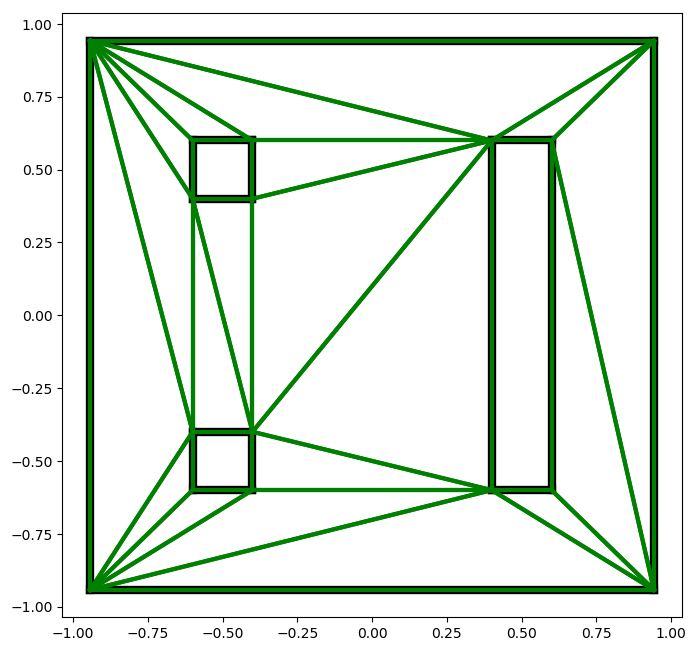

In [23]:
py = ([vec3(0.9423, 0.9423, 0.0577), vec3(-0.9423, 0.9423, 0.0577), vec3(-0.9423, -0.9423, 0.0577), vec3(0.9423, -0.9423, 0.0577)], [[vec3(0.6000, 0.6000, 0.0577), vec3(0.4000, 0.6000, 0.0577), vec3(0.4000, -0.6000, 0.0577), vec3(0.6000, -0.6000, 0.0577)], [vec3(-0.6000, -0.6000, 0.0577), vec3(-0.4000, -0.6000, 0.0577), vec3(-0.4000, -0.4000, 0.0577), vec3(-0.6000, -0.4000, 0.0577)], [vec3(-0.4000, 0.6000, 0.0577), vec3(-0.6000, 0.6000, 0.0577), vec3(-0.6000, 0.4000, 0.0577), vec3(-0.4000, 0.4000, 0.0577)]])
t = triangulation(py, 0.0001, None)

f, ax = plot()
plot_polygon(ax, py, lw=6)
for tri in t.simplices():
    plot_loop(ax, list(tri), col='g')


In [ ]:
def edges_to_loops(edges):
    loops = [list(edges[0])]
    unfin = edges[1:]
    while unfin:
        u, v = unfin.pop(0)
        w = None
        for loop in loops:
            for i, p in enumerate(loop):
                if p.isnear(u):
                    w = v
                    break
                elif p.isnear(v):
                    w = u
                    break
            if w is not None:
                if i > 0:
                    loop.append(w)
                else:
                    loop.insert(0, w)
                break
                    
                    
    return loops

def loops_to_edges(loops):
    edges = []
    return edges